In [47]:
import lsst.daf.butler as dafButler
import numpy as np
import astropy.table
import matplotlib.pyplot as plt
import lsst.afw.display as afwDisplay
from functools import lru_cache
import os
afwDisplay.setDefaultBackend("matplotlib")

In [2]:
butler = dafButler.Butler(os.environ['REPO'])

In [3]:
# get the fakes 
fakes = butler.get(
    "DEEP_fakes", collections="DEEP/fakes",
).asAstropy()

In [4]:
# get the available difference images
detector = 4

refs = list(set(list(
    butler.registry.queryDatasets(
        "differenceExp", collections="DEEP/20190403/A0c", where=f"instrument='DECam' and detector={detector}"
    )
)))

refs = {ref.dataId['visit'] : ref for ref in refs}

In [5]:
# get the visits for which difference images are available
visits = list(refs.keys())

In [49]:
visits[0]

845948

In [6]:
# filter fakes to this CCD and set of visits for which we have a difference images
f = fakes[fakes['CCDNUM'] == detector]
mask = np.zeros(len(f)).astype(bool)
for visit in visits:
    mask |= f['EXPNUM'] == visit
f = f[mask]

In [7]:
f

RA,DEC,EXPNUM,CCDNUM,ORBITID,aei,mjd_mid,TDB,xv,H_VR,AMP,PERIOD,PHASE,d,observatory,r,MAG,type
float64,float64,int32,int64,int64,float64[6],float64,float64,float64[6],float64,float64,float64,float64,float64,float64[3],float64,float64,str8
-143.9352217876162,-11.23051029609669,845872,4,2099,66.83157577666151 .. -193.84165486729444,58577.21447994315,19.254525066949327,-59.33027127225589 .. 0.21025719639297186,7.948873683564418,0.05941069688391487,1917.6138972256906,2.2197648966213395,74.51687730656002,-0.9723130239773092 .. -0.09252563558321852,73.60363877861263,26.58715925051952,tno
-143.9352396609452,-11.230502318364525,845873,4,2099,66.83157577666151 .. -193.84165486729444,58577.21619125002,19.25452975225221,-59.33026987950022 .. 0.21025720285066282,7.948873683564418,0.05941069688391487,1917.6138972256906,2.2197648966213395,74.51687756581305,-0.9723063207295254 .. -0.09253705087391721,73.60362672057957,26.587296052471746,tno
-143.9352582170883,-11.230494035731535,845874,4,2099,66.83157577666151 .. -193.84165486729444,58577.21796780527,19.254534616195542,-59.33026843364166 .. 0.21025720955457103,7.948873683564418,0.05941069688391487,1917.6138972256906,2.2197648966213395,74.5168778349508,-0.9722993567140087 .. -0.09254890132897936,73.60361420790251,26.58744296769066,tno
-143.9352760911034,-11.230486057428033,845875,4,2099,66.83157577666151 .. -193.84165486729444,58577.21967893464,19.2545393010123,-59.33026704103022 .. 0.21025721601159095,7.948873683564418,0.05941069688391487,1917.6138972256906,2.2197648966213395,74.5168780941769,-0.9722926441883359 .. -0.09256031528333111,73.60360216096939,26.58758917729186,tno
-143.93529399904745,-11.230478063822085,845876,4,2099,66.83157577666151 .. -193.84165486729444,58577.22139319794,19.25454399440946,-59.33026564586807 .. 0.21025722248043666,7.948873683564418,0.05941069688391487,1917.6138972256906,2.2197648966213395,74.51687835387774,-0.9722859144864211 .. -0.09257175006685092,73.60359009683772,26.587740271990437,tno
-143.93531192593898,-11.230470061582771,845877,4,2099,66.83157577666151 .. -193.84165486729444,58577.2231091633,19.254548692466642,-59.330264249320535 .. 0.21025722895570464,7.948873683564418,0.05941069688391487,1917.6138972256906,2.2197648966213395,74.51687861383641,-0.9722791732233937 .. -0.09258319613091369,73.60357802561398,26.58789613284669,tno
-143.93532985351277,-11.230462058845076,845878,4,2099,66.83157577666151 .. -193.84165486729444,58577.22482508671,19.254553390408773,-59.33026285280709 .. 0.2102572354308135,7.948873683564418,0.05941069688391487,1917.6138972256906,2.2197648966213395,74.51687887378871,-0.9722724272637077 .. -0.09259464183675381,73.60356595959146,26.588056595470995,tno
-143.93534786129106,-11.230454020091338,845879,4,2099,66.83157577666151 .. -193.84165486729444,58577.226548581515,19.254558109080563,-59.33026145013139 .. 0.21025724193449338,7.948873683564418,0.05941069688391487,1917.6138972256906,2.2197648966213395,74.51687913488804,-0.972265646659101 .. -0.09260613797159109,73.60355384527348,26.588222389035348,tno
-143.9353656936292,-11.230446059427496,845880,4,2099,66.83157577666151 .. -193.84165486729444,58577.228255184666,19.25456278150523,-59.330260061203035 .. 0.21025724837443086,7.948873683564418,0.05941069688391487,1917.6138972256906,2.2197648966213395,74.51687939342834,-0.9722589277096986 .. -0.09261752136145085,73.60354185457965,26.58839110952355,tno


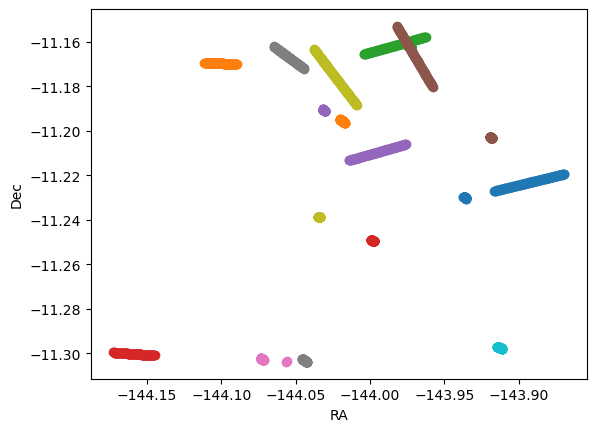

In [12]:
# plot fakes on CCD
for group in f.group_by("ORBITID").groups:
    plt.scatter(group['RA'], group['DEC'])
plt.xlabel("RA")
plt.ylabel("Dec")
plt.show()

In [43]:
@lru_cache(maxsize=1024) # cache this function since it is slow
def cutout_pixel(butler, ref, x, y, w, h):
    import lsst.geom
    corner = lsst.geom.Point2I(x - w/2, y - h/2)
    bbox = lsst.geom.Box2I(corner, lsst.geom.Extent2I(w, h))
    image_bbox = butler.get(ref.makeComponentRef("bbox"))
    bbox.clip(image_bbox)
    return butler.get(ref, parameters=dict(bbox=bbox))

def cutout_sky(butler, ref, ra, dec, w, h):
    import lsst.geom
    wcs = butler.get(ref.makeComponentRef("wcs"))
    x, y = wcs.skyToPixelArray([ra], [dec])
    return cutout_pixel(butler, ref, x[0], y[0], w, h)

def sky_to_xy(wcs, ra, dec):
    import lsst.geom
    x, y = wcs.skyToPixelArray(ra, dec)
    return x, y
    
def pixels_for_fake(ref, fakes):
    f = fakes[fakes['EXPNUM'] == ref.dataId['visit']]
    wcs = butler.get(ref.makeComponentRef("wcs"))
    x, y = wcs.skyToPixelArray(f['RA'] * np.pi/180, f['DEC'] * np.pi/180)
    f['x'] = x
    f['y'] = y
    return f

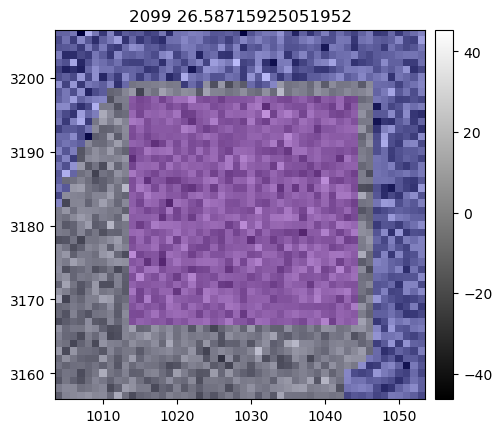

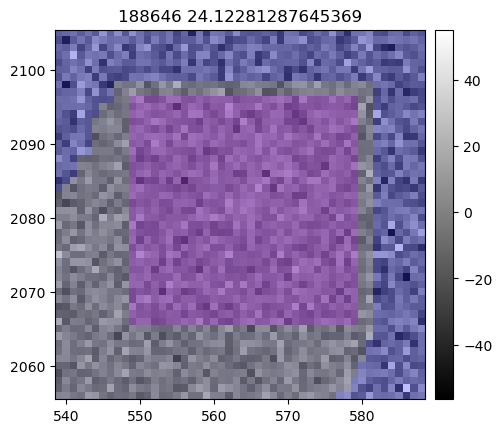

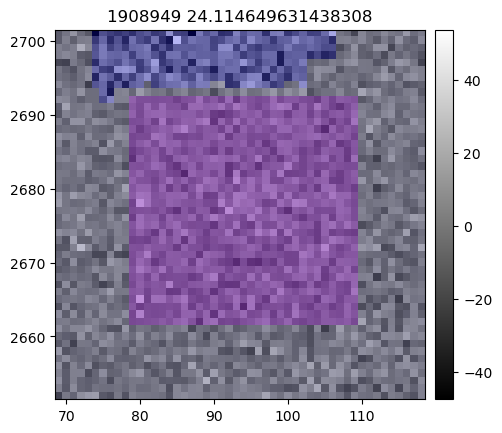

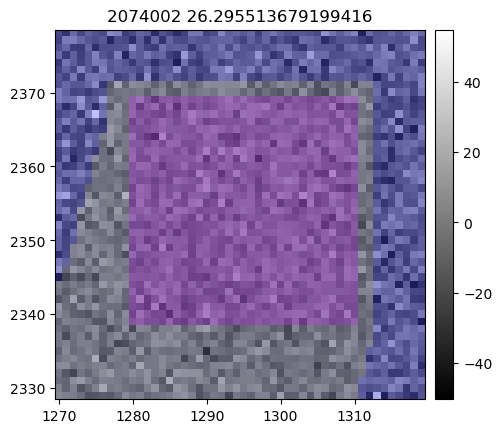

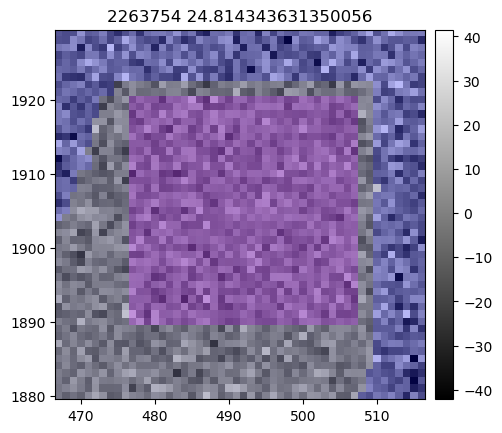

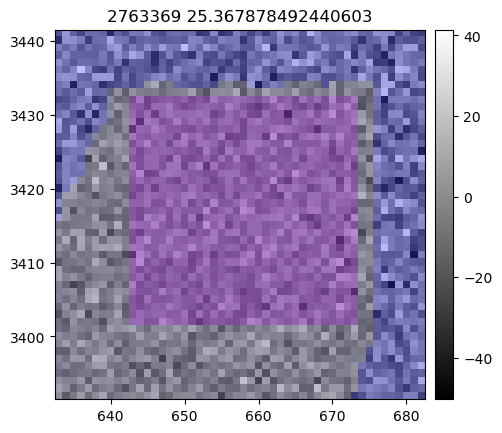

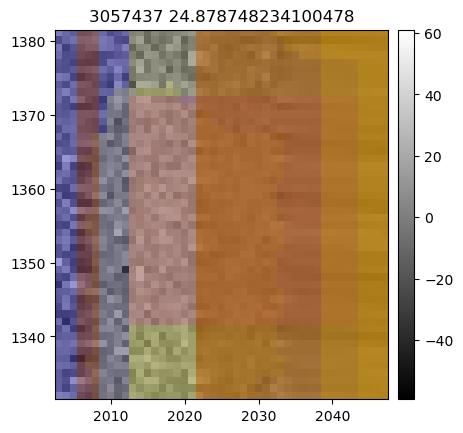

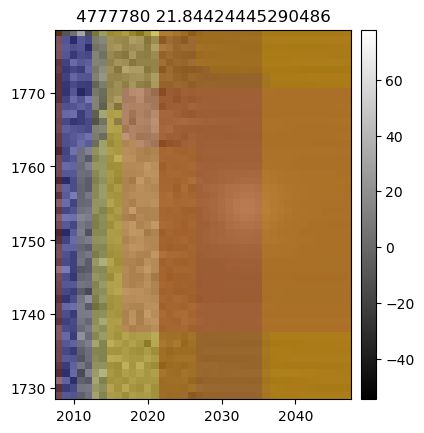

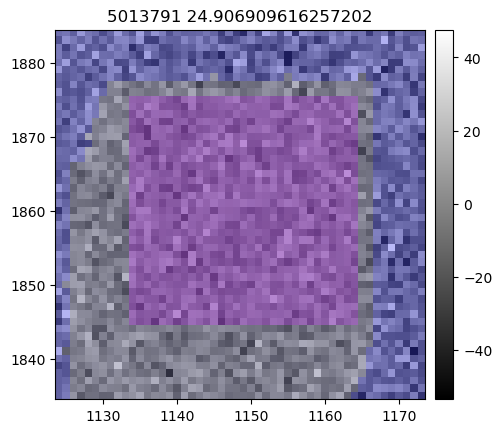

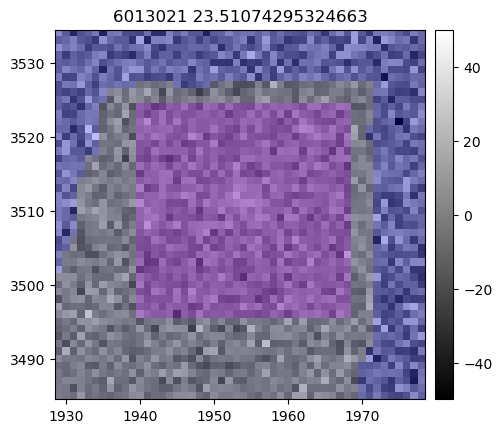

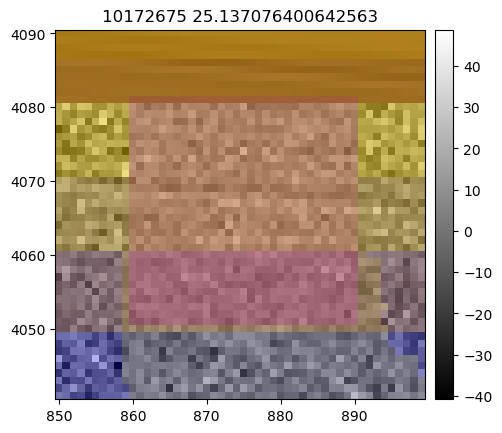

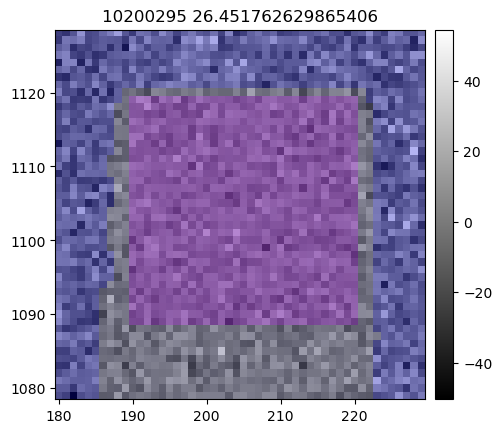

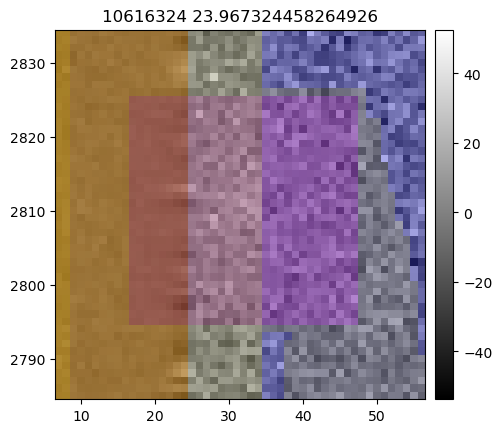

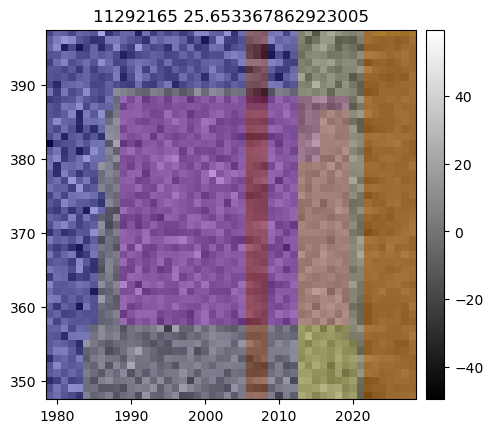

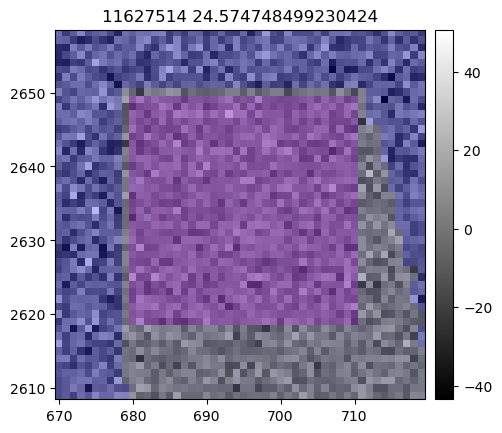

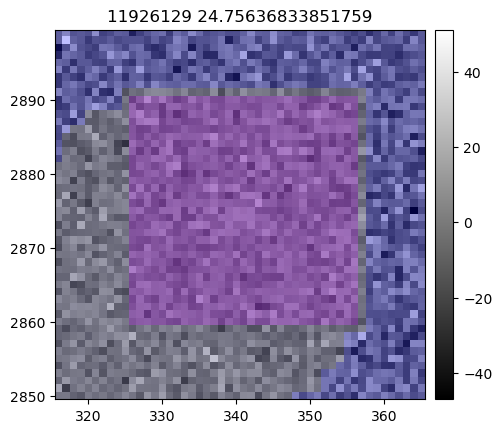

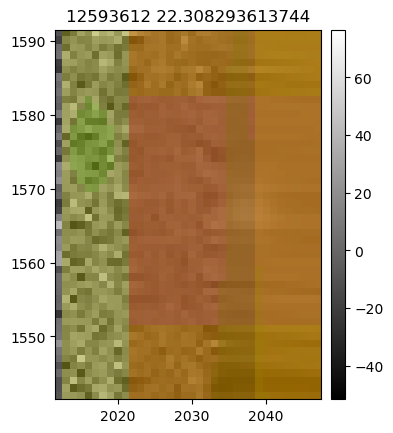

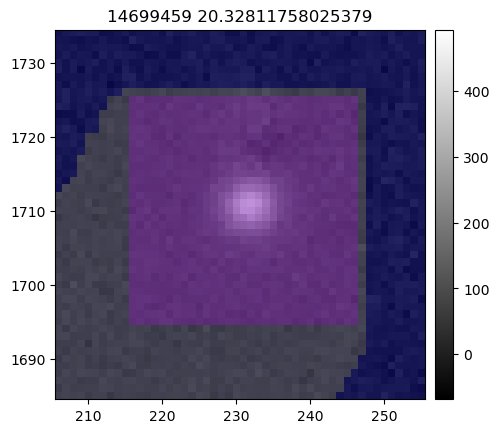

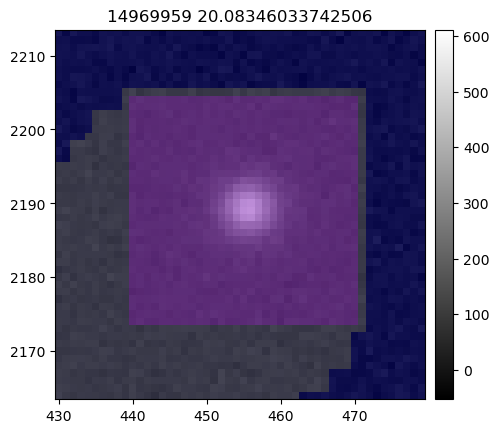

In [14]:
# plot a cutout from each orbit
for group in f.group_by("ORBITID").groups:
    for row in group:
        visit = row['EXPNUM']
        cutout = cutout_sky(butler, refs[visit], row['RA']*np.pi/180, row['DEC']*np.pi/180, 50, 50)

        fig = plt.figure()
        display = afwDisplay.Display(frame=fig)
        display.mtv(cutout)
        plt.title(f"{row['ORBITID']} {row['MAG']}")
        plt.show()
        break


In [23]:
def forced_photometry(exposure, x, y, shift=[0, 0]):
    import lsst.afw.image
    import lsst.geom
    import scipy 
    
    p = lsst.geom.Point2D(x, y)
    eBBox = exposure.getBBox()
    psfBBox = exposure.psf.computeImageBBox(p)
    psfBBox.clip(eBBox)

    model = lsst.afw.image.ImageD(exposure.psf.computeImage(p), psfBBox).array
    model = scipy.ndimage.shift(model, shift)
    stamp = lsst.afw.image.ImageD(lsst.afw.image.ImageF(exposure.image, psfBBox), deep=True).array
    weights = 1/lsst.afw.image.ImageD(lsst.afw.image.ImageF(exposure.variance, psfBBox), deep=True).array
    a = np.sum(model * model * weights, axis=(0, 1))
    c = np.sum(model * stamp * weights, axis=(0, 1))
    f = c/a
    sigma = 1/np.sqrt(a)
    snr = c / np.sqrt(a)
    mag = exposure.getPhotoCalib().instFluxToMagnitude(f)
    mag_high = exposure.getPhotoCalib().instFluxToMagnitude(f - sigma) # removing flux gives a higher mag
    mag_low = exposure.getPhotoCalib().instFluxToMagnitude(f + sigma) # adding flux gives a lower mag
    mag_err = [mag - mag_low, mag_high - mag]

    logL = -0.5 * np.sum(weights * (f * model - stamp) ** 2)
    return {
        "logL": logL, 
        "a": a,
        "c": c,
        "flux": f, 
        "sigma": sigma, 
        "SNR": snr,
        "mag": mag,
        "mag_err": mag_err
    }


def forced_photometry_sky(exposure, ra, dec):
    wcs = exposure.wcs
    x, y = wcs.skyToPixelArray([ra], [dec])
    return forced_photometry(exposure, x[0], y[0])

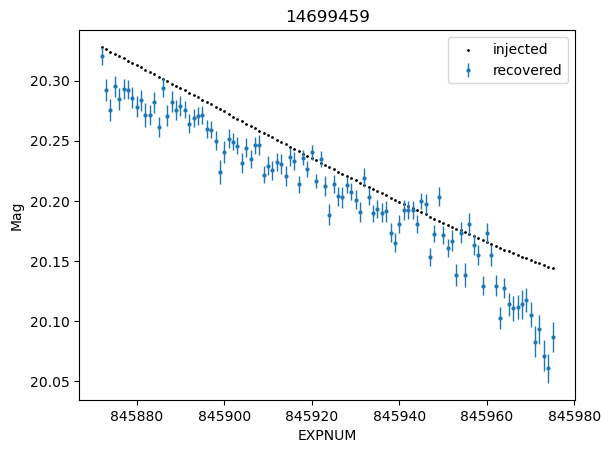

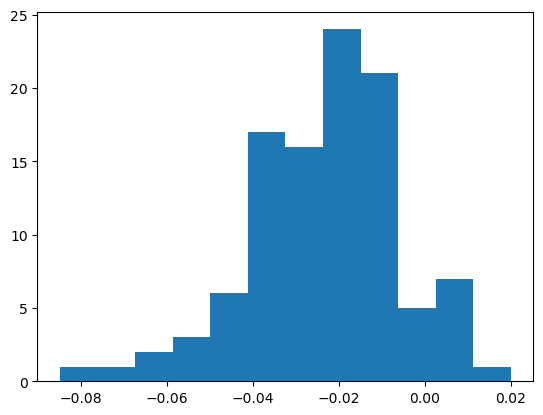

In [44]:
# perform forced photometry on one fake
orbit = f[f['ORBITID'] == 14699459]
forced_mag = []
forced_mag_err = []
for row in orbit:
    visit = row['EXPNUM']
    ra, dec = row['RA'] * np.pi/180, row['DEC'] * np.pi/180
    cutout = cutout_sky(butler, refs[visit], ra, dec, 50, 50)
    result = forced_photometry_sky(cutout, ra, dec)
    forced_mag.append(result['mag'])
    forced_mag_err.append(result['mag_err'])
    
fig = plt.figure(dpi=100)
plt.errorbar(
    orbit['EXPNUM'], 
    forced_mag, 
    yerr=np.array(forced_mag_err).T, 
    fmt='o',
    ms=2,
    lw=1,
    label="recovered"
)
plt.scatter(orbit['EXPNUM'], orbit['MAG'], color="k", s=1, label="injected")
plt.xlabel("EXPNUM")
plt.ylabel("Mag")
plt.title(orbit[0]['ORBITID'])
plt.legend()
plt.show()

fig = plt.figure(dpi=100)
mag_residuals = np.array(forced_mag) - orbit['MAG']
plt.hist(mag_residuals, bins='auto')
plt.show()

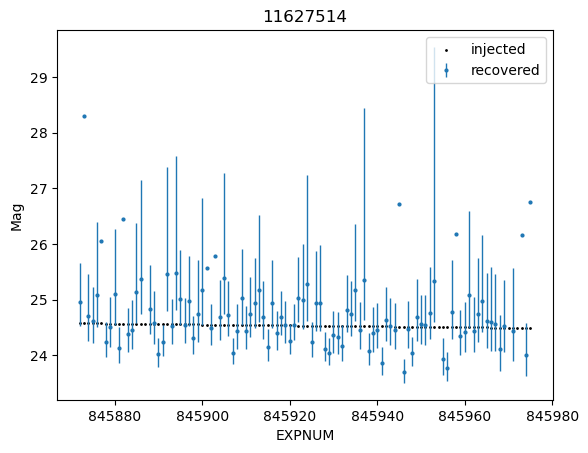

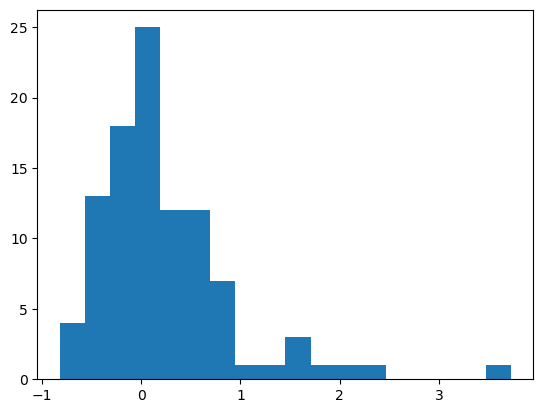

In [45]:
# perform forced photometry on a fainter fake
orbit = f[f['ORBITID'] == 11627514]
forced_mag = []
forced_mag_err = []
for row in orbit:
    visit = row['EXPNUM']
    ra, dec = row['RA'] * np.pi/180, row['DEC'] * np.pi/180
    cutout = cutout_sky(butler, refs[visit], ra, dec, 50, 50)
    result = forced_photometry_sky(cutout, ra, dec)
    forced_mag.append(result['mag'])
    forced_mag_err.append(result['mag_err'])
    
fig = plt.figure(dpi=100)
plt.errorbar(
    orbit['EXPNUM'], 
    forced_mag, 
    yerr=np.array(forced_mag_err).T, 
    fmt='o',
    ms=2,
    lw=1,
    label="recovered"
)
plt.scatter(orbit['EXPNUM'], orbit['MAG'], color="k", s=1, label="injected")
plt.xlabel("EXPNUM")
plt.ylabel("Mag")
plt.title(orbit[0]['ORBITID'])
plt.legend()
plt.show()

fig = plt.figure(dpi=100)
mag_residuals = np.array(forced_mag) - orbit['MAG']
plt.hist(mag_residuals, bins='auto')
plt.show()